In [143]:
%matplotlib inline
%config InlineBackend.close_figures=False 
import ipywidgets as widgets
from IPython.display import display,clear_output, Audio
from sklearn.metrics import confusion_matrix
from ipywidgets import HBox, VBox, Layout
import matplotlib.pyplot as plt
from datetime import datetime
from random import shuffle
import sounddevice as sd
import pandas as pd
import numpy as np
import wavio
import time
import os

In [ ]:
# Import classes and init random indexes
results = {'index': [],
           'truth': [],
           'prediction': [],
           'issue': []}
df_summary = pd.read_csv('kitchen20.csv')
rand_idxs = list(range(len(df_summary)))
shuffle(rand_idxs)
name = None

# Read audio fuction
def play(idx):
    row = df_summary.loc[idx]
    audioRate = 44100
    sound = wavio.read(row.path).data.T[0]
    sd.play(sound, audioRate)
    
    
def save(df_results, name):
    if not os.path.exists('./results'):
        os.makedirs('./results')
    df_results.to_csv('./results/{}_{:%y%m%d_%T}.csv'.format(
        name, datetime.now()))
    print('Saved')

    
def plot_confusion_matrix(y_true, y_pred, classes,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(10,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


#######################
# Instantiate the UI

### Class buttons
class_buttons = widgets.ToggleButtons(
    options=['blender', 'boiling-water', 'book', 'chopping', 'clean-dishes',
             'cupboard', 'cutlery', 'dishwasher', 'drawer', 'eat', 'fridge',
             'frying-pan', 'juicer', 'microwave', 'peel', 'plates', 'stove-burner',
             'stove-fan', 'sweep', 'water-flowing'],
    description='Class:')

### Play button    
play_button = widgets.Button(
    description='replay audio {}  -  1/80'.format(rand_idxs[-1]),
    layout=Layout(width='auto'))

@play_button.on_click
def play_audio(b):
    play(rand_idxs[-1])

### Issue text
issue_text = widgets.Text(
    description='Report issue:',
    value='',
    continus_update=True,
    disabled=False)

### Answer button
answer_button = widgets.Button(
    description='',
    layout=Layout(width='auto'))

### Next button
next_button = widgets.Button(
    description='Next',
    layout=Layout(width='auto'))

@next_button.on_click
def next_audio(b):
    # Record prediction
    played_idx = rand_idxs[-1]
    results['index'].append(played_idx)
    results['truth'].append(df_summary.category[played_idx])
    results['prediction'].append(class_buttons.value)
    results['issue'].append(issue_text.value)
    
    # Show answer
    answer_button.layout.visibility = 'visible'
    answer_button.description = df_summary.category[played_idx]
    if df_summary.category[played_idx] == class_buttons.value:
        answer_button.style.button_color = 'lightgreen'
    else:
        answer_button.style.button_color = 'red'
    time.sleep(1)
    answer_button.layout.visibility = 'hidden'

    # Change current index
    rand_idxs.pop()
    counter = len(df_summary) - len(rand_idxs) + 1
    
    # Update view
    if counter <= 80:
        play(rand_idxs[-1])
        play_button.description='replay audio {}  -  {}/80'.format(
            rand_idxs[-1], counter)
        next_button.layout.visibility = 'hidden'
        issue_text.value = ''
        time.sleep(4)
        next_button.layout.visibility = 'visible'
    else:  # End game
        tab.layout.visibility = 'hidden'
        next_button.layout.visibility = 'hidden'
        df_results = pd.DataFrame(results)
        save(df_results, name)
        classes = list(set(df_results.truth.append(df_results.prediction)))
        y_test = [classes.index(c) for c in df_results.truth]
        y_pred = [classes.index(c) for c in df_results.prediction]
        plot_confusion_matrix(y_test, y_pred, classes=classes)
        acc = (np.array(y_test) == np.array(y_pred)).mean() * 100
        print('Your accuracy is {}%'.format(acc))
        print('Thaaaaaank youuuuuu :D')
    
# Define visual box
tab = VBox(children=[play_button,
                     class_buttons,
                     issue_text,
                     next_button,
                     answer_button])

print("This is going to last in between 10 and 15 minutes")
name = input('What is your name ?')
display(tab)
play(rand_idxs[-1])

---
## Get final classes in Kitchen20

In [163]:
class Ktchn(object):
    df_ktchn = pd.read_csv('kitchen20.csv')
    df_ktchn = df_ktchn[df_ktchn.fold <= 5]
        
    @classmethod
    def legit_row(cls, row):
        return row['index'] in df_ktchn.index
    
    @classmethod
    def legit_df(cls, df):
        idxs = [cls.legit_row(row) for _, row in df.iterrows()]
        return idxs
    
    @classmethod
    def get_legit_df(cls, df):
        idxs = cls.legit_df(df)
        return df[idxs]


df = Ktchn.get_legit_df(df)
df.shape

(57, 5)

---
## Show the leader-board

In [168]:
from glob import glob

def load_all_results(fPattern='./results/*.csv'):
    dfs = {}
    for fPath in glob(fPattern):
        df = pd.read_csv(fPath)
        name = fPath[10:].split('_')[0]
        df = Ktchn.get_legit_df(df)
        dfs[name] = df
    return dfs

dfs = load_all_results()
for name, df in dfs.items():
    print('{} scored {}'.format(
            name, 
            (df.truth == df.prediction).mean() * 100) )

print('--')
df_overall = pd.concat(dfs)
print('Overllalls', (df_overall.truth == df_overall.prediction).mean() * 100)
print(len(df_overall))

marc scored 95.65217391304348
Arturo scored 65.51724137931035
Edouard scored 78.84615384615384
AgentWallE scored 77.19298245614034
Tom scored 72.1311475409836
Ferran scored 82.75862068965517
Hugo Caselles-Dupré scored 90.32258064516128
Mehdi scored 64.40677966101694
Alban scored 81.25
Manu scored 80.35714285714286
aMazel scored 78.18181818181819
Giuseppe scored 82.53968253968253
MESLOUH scored 89.0625
mina scored 72.58064516129032
Bahar scored 77.58620689655173
Maëva scored 76.66666666666667
Max scored 77.04918032786885
--
Overllalls 78.81526104417671
996


## Show the inter-session accuracy trend

You'll notice how the accuracy increasess after some iterations, surely when the user becomes used to the task

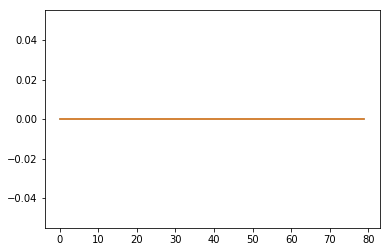

In [165]:
from scipy.ndimage.filters import gaussian_filter1d

df_overall['acc'] = (df_overall.truth == df_overall.prediction) * 1

fig, ax = plt.subplots()
accs = np.zeros(80)
for name in df_overall.index.levels[0]:
    acc = df_overall.loc[name].acc
    acc = np.nan_to_num(acc)
    if acc.shape == accs.shape:
        accs += acc

accs = accs# / len(df_overall.index.levels[0])
ax.plot(accs)
ysmoothed = gaussian_filter1d(accs, sigma=4)
ax.plot(ysmoothed)

## Confusion matrix

In [219]:
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize=(10,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd' if cm.dtype == int else '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


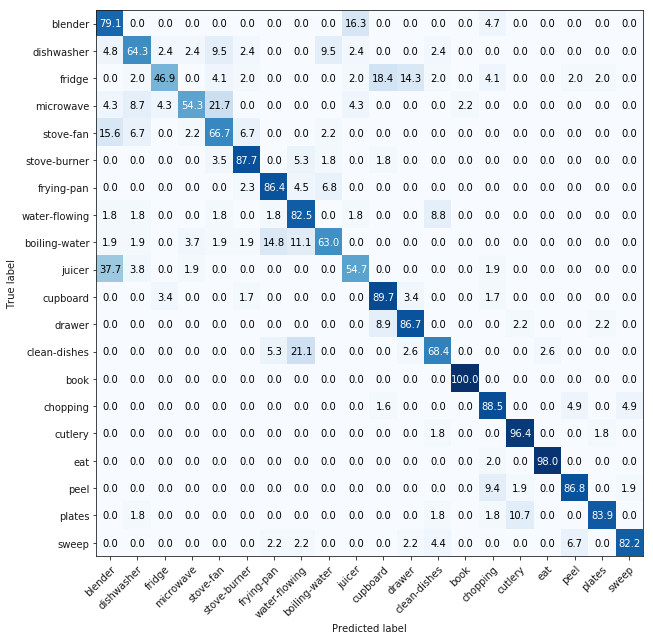

In [239]:
from sklearn.metrics import confusion_matrix
# classes = list(set(df_overall.truth))
classes = ('blender,dishwasher,fridge,microwave,stove-fan,stove-burner,'
           'frying-pan,water-flowing,boiling-water,juicer,cupboard,drawer,'
           'clean-dishes,book,chopping,cutlery,eat,peel,plates,sweep').split(',')
category = [classes.index(c) for c in df_overall.truth]
predictions = [classes.index(c) for c in df_overall.prediction]
cm = confusion_matrix(category, predictions)
cm = np.array([l / l.sum() * 100 for l in cm])
plot_confusion_matrix(cm, classes)


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


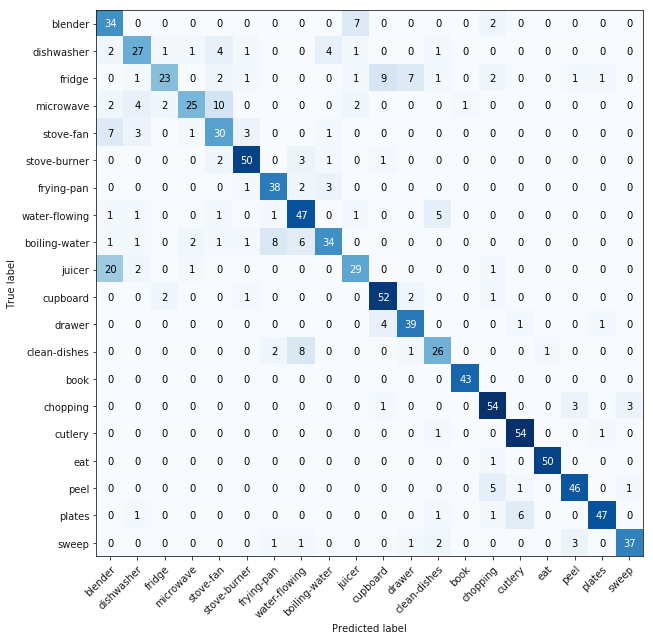

In [240]:
from scipy.sparse.csgraph import reverse_cuthill_mckee
import scipy
import itertools
list(itertools.permutations([1, 2, 3]))
import seaborn as sns
sns.set()
sns.reset_orig()

cm = confusion_matrix(category, predictions)
cm = np.array(cm)
plot_confusion_matrix(cm, classes)
# cm = np.array([l / l.sum() * 100 for l in cm])
# perm = reverse_cuthill_mckee(scipy.sparse.csr_matrix(cm))
# plot_confusion_matrix(cm[perm[:,None],perm], [classes[i] for i in perm])

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


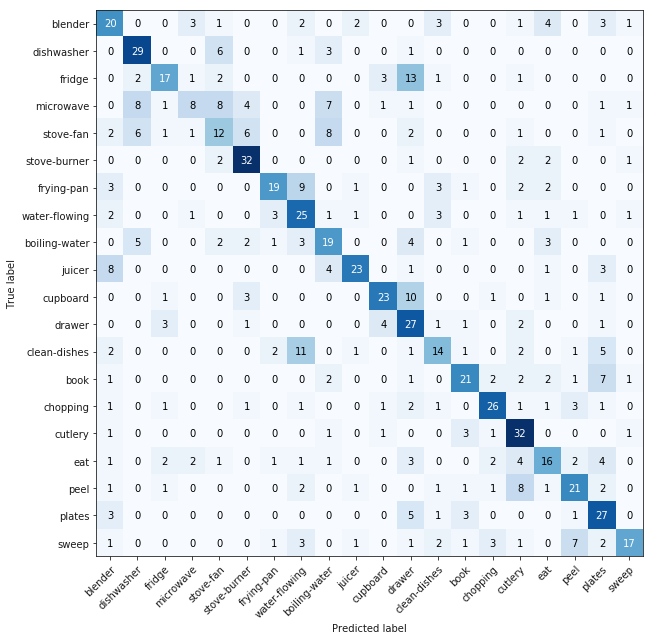

In [241]:
classes = ('blender,dishwasher,fridge,microwave,stove-fan,stove-burner,'
           'frying-pan,water-flowing,boiling-water,juicer,cupboard,drawer,'
           'clean-dishes,book,chopping,cutlery,eat,peel,plates,sweep').split(',')
confusion = np.array([
 [20, 0, 0, 3, 1, 0, 0, 2, 0, 2, 0, 0, 3, 0, 0, 1, 4, 0, 3, 1],
 [0, 29, 0, 0, 6, 0, 0, 1, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 2, 17, 1, 2, 0, 0, 0, 0, 0, 3, 13, 1, 0, 0, 1, 0, 0, 0, 0],
 [0, 8, 1, 8, 8, 4, 0, 0, 7, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
 [2, 6, 1, 1, 12, 6, 0, 0, 8, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 2, 32, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1],
 [3, 0, 0, 0, 0, 0, 19, 9, 0, 1, 0, 0, 3, 1, 0, 2, 2, 0, 0, 0],
 [2, 0, 0, 1, 0, 0, 3, 25, 1, 1, 0, 0, 3, 0, 0, 1, 1, 1, 0, 1],
 [0, 5, 0, 0, 2, 2, 1, 3, 19, 0, 0, 4, 0, 1, 0, 0, 3, 0, 0, 0],
 [8, 0, 0, 0, 0, 0, 0, 0, 4, 23, 0, 1, 0, 0, 0, 0, 1, 0, 3, 0],
 [0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 23, 10, 0, 0, 1, 0, 1, 0, 1, 0],
 [0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 4, 27, 1, 1, 0, 2, 0, 0, 1, 0],
 [2, 0, 0, 0, 0, 0, 2, 11, 0, 1, 0, 1, 14, 1, 0, 2, 0, 1, 5, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 21, 2, 2, 2, 1, 7, 1],
 [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 2, 1, 0, 26, 1, 1, 3, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 3, 1, 32, 0, 0, 0, 1],
 [1, 0, 2, 2, 1, 0, 1, 1, 1, 0, 0, 3, 0, 0, 2, 4, 16, 2, 4, 0],
 [1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 8, 1, 21, 2, 0],
 [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 3, 0, 0, 0, 1, 27, 0],
 [1, 0, 0, 0, 0, 0, 1, 3, 0, 1, 0, 1, 2, 1, 3, 1, 0, 7, 2, 17]])

plot_confusion_matrix(confusion, classes)